# Custom Models with MMM components

The underlying functionality of the `MMM` class allow for lots of flexibility. 

With a little knowledge of `PyMC`, there is a lot of flexibility to create different models 

In [1]:
from functools import partial

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing import mmm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed = sum(map(ord, "PyMC-Marketing provides flexible model components"))
rng = np.random.default_rng(seed)

draw = partial(pm.draw, random_seed=rng)

## Media Transformations

There are classes for each of the adstock and saturation transformations. They can be imported from the `pymc_marketing.mmm` module.

Each of the transformation will have a set of default priors

In [3]:
saturation = mmm.MichaelisMentenSaturation()
saturation.function_priors

{'alpha': {'dist': 'Gamma', 'kwargs': {'mu': 2, 'sigma': 1}},
 'lam': {'dist': 'HalfNormal', 'kwargs': {'sigma': 1}}}

### Sampling Transformation Function

In [4]:
prior = saturation.sample_prior()
prior

Sampling: [saturation_alpha, saturation_lam]


<xarray.Dataset> Size: 12kB
Dimensions:           (chain: 1, draw: 500)
Coordinates:
  * chain             (chain) int64 8B 0
  * draw              (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Data variables:
    saturation_alpha  (chain, draw) float64 4kB 1.051 2.499 ... 1.848 1.912
    saturation_lam    (chain, draw) float64 4kB 1.132 1.057 ... 2.1 0.2299
Attributes:
    created_at:                 2024-06-14T07:47:09.419009
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.14.0

Sampling: []


Output()

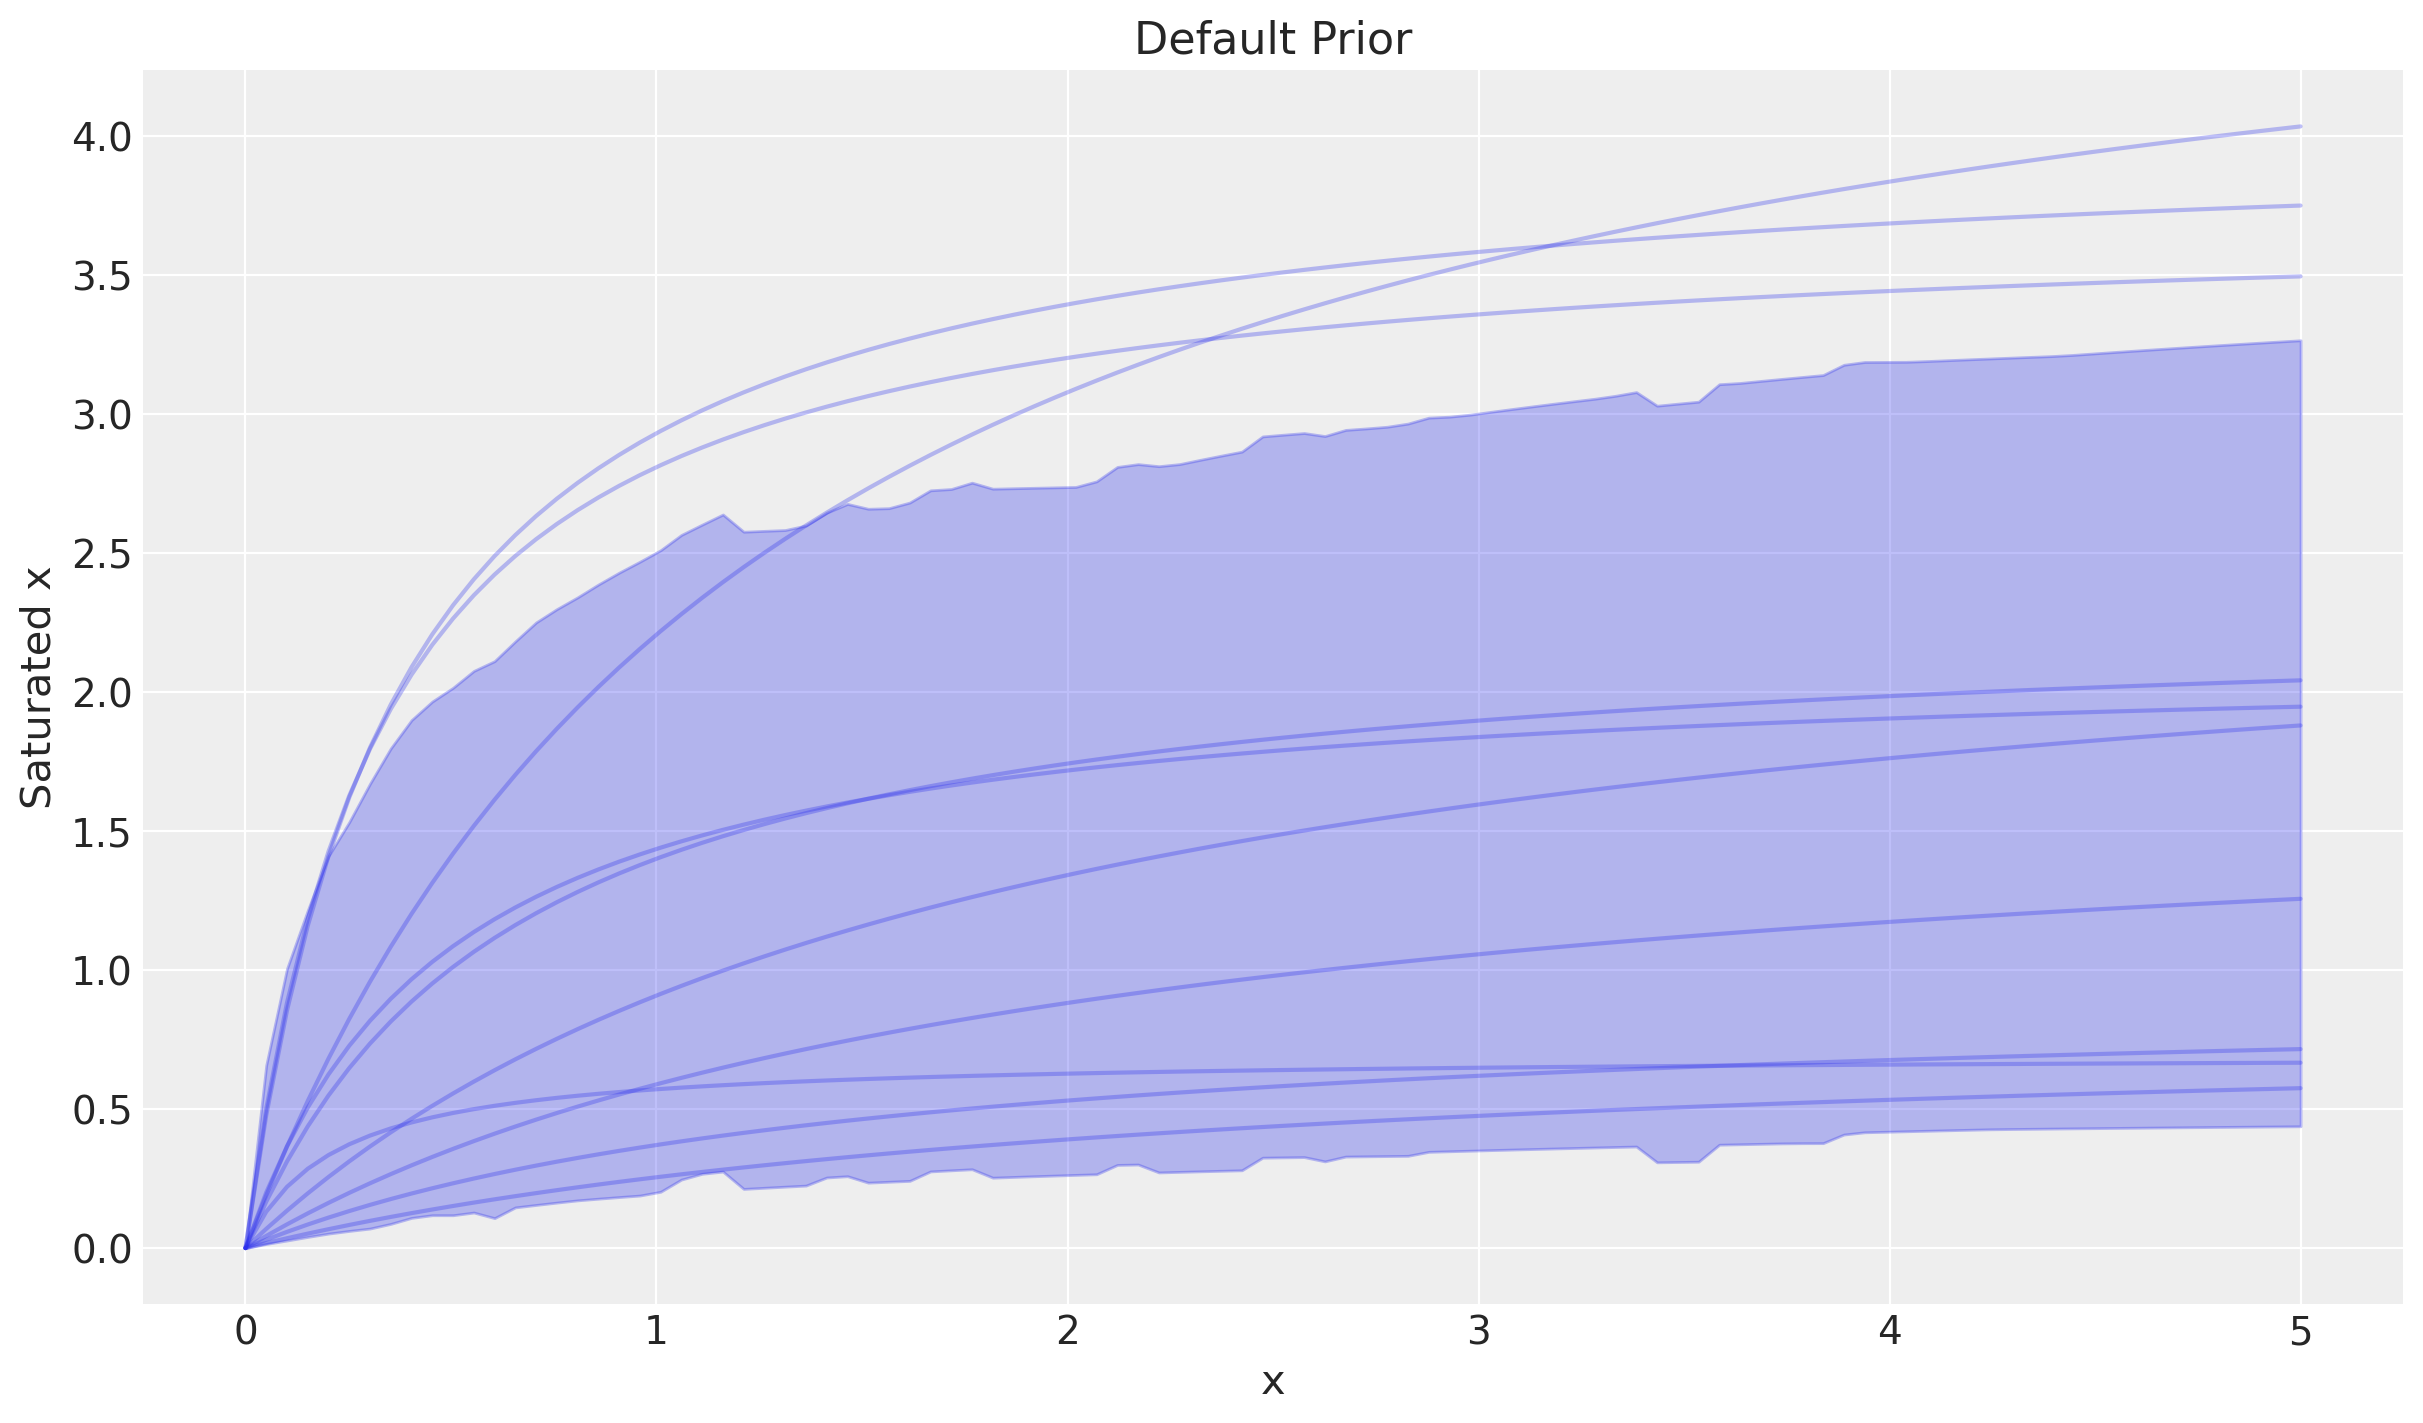

In [5]:
curve = saturation.sample_curve(prior, max_value=5)
_, axes = saturation.plot_curve(curve)
axes[0].set(
    ylabel="Saturated x",
    title="Default Prior",
);

### Using in PyMC Model

To illustrate using our transformation, we will generate some spend date which we will

In [6]:
n_dates = 52 * 2
dates = pd.date_range("2023-01-01", periods=n_dates, freq="W-MON")

channels = ["C1", "C2", "C3"]
n_channels = len(channels)

spends_rv = pm.HalfNormal.dist(size=(n_dates, n_channels))

spends = pd.DataFrame(draw(spends_rv), index=dates, columns=channels)
spends.head()

,C1,C2,C3
2023-01-02,0.759727,0.092559,1.105554
2023-01-09,0.831529,0.515029,2.319163
2023-01-16,0.213291,0.638455,0.448554
2023-01-23,0.084847,0.029676,1.092030
2023-01-30,0.650699,0.008388,1.368355


The transformations have an `apply` method which will: 

- create distributions based on prior specification
- apply the transformation to the data

In [ ]:
help(saturation.apply)

Note above that the default priors do not have a channel dimension. In order to use with the in our model with "channel" dim, we have to add the dims to each of the function priors

In [7]:
for config in saturation.function_priors.values():
    config["dims"] = "channel"

saturation.function_priors

{'alpha': {'dist': 'Gamma',
  'kwargs': {'mu': 2, 'sigma': 1},
  'dims': 'channel'},
 'lam': {'dist': 'HalfNormal', 'kwargs': {'sigma': 1}, 'dims': 'channel'}}

In [9]:
prior = saturation.sample_prior(coords={"channel": channels})
curve = saturation.sample_curve(prior)

Sampling: [saturation_alpha, saturation_lam]
Sampling: []


Output()

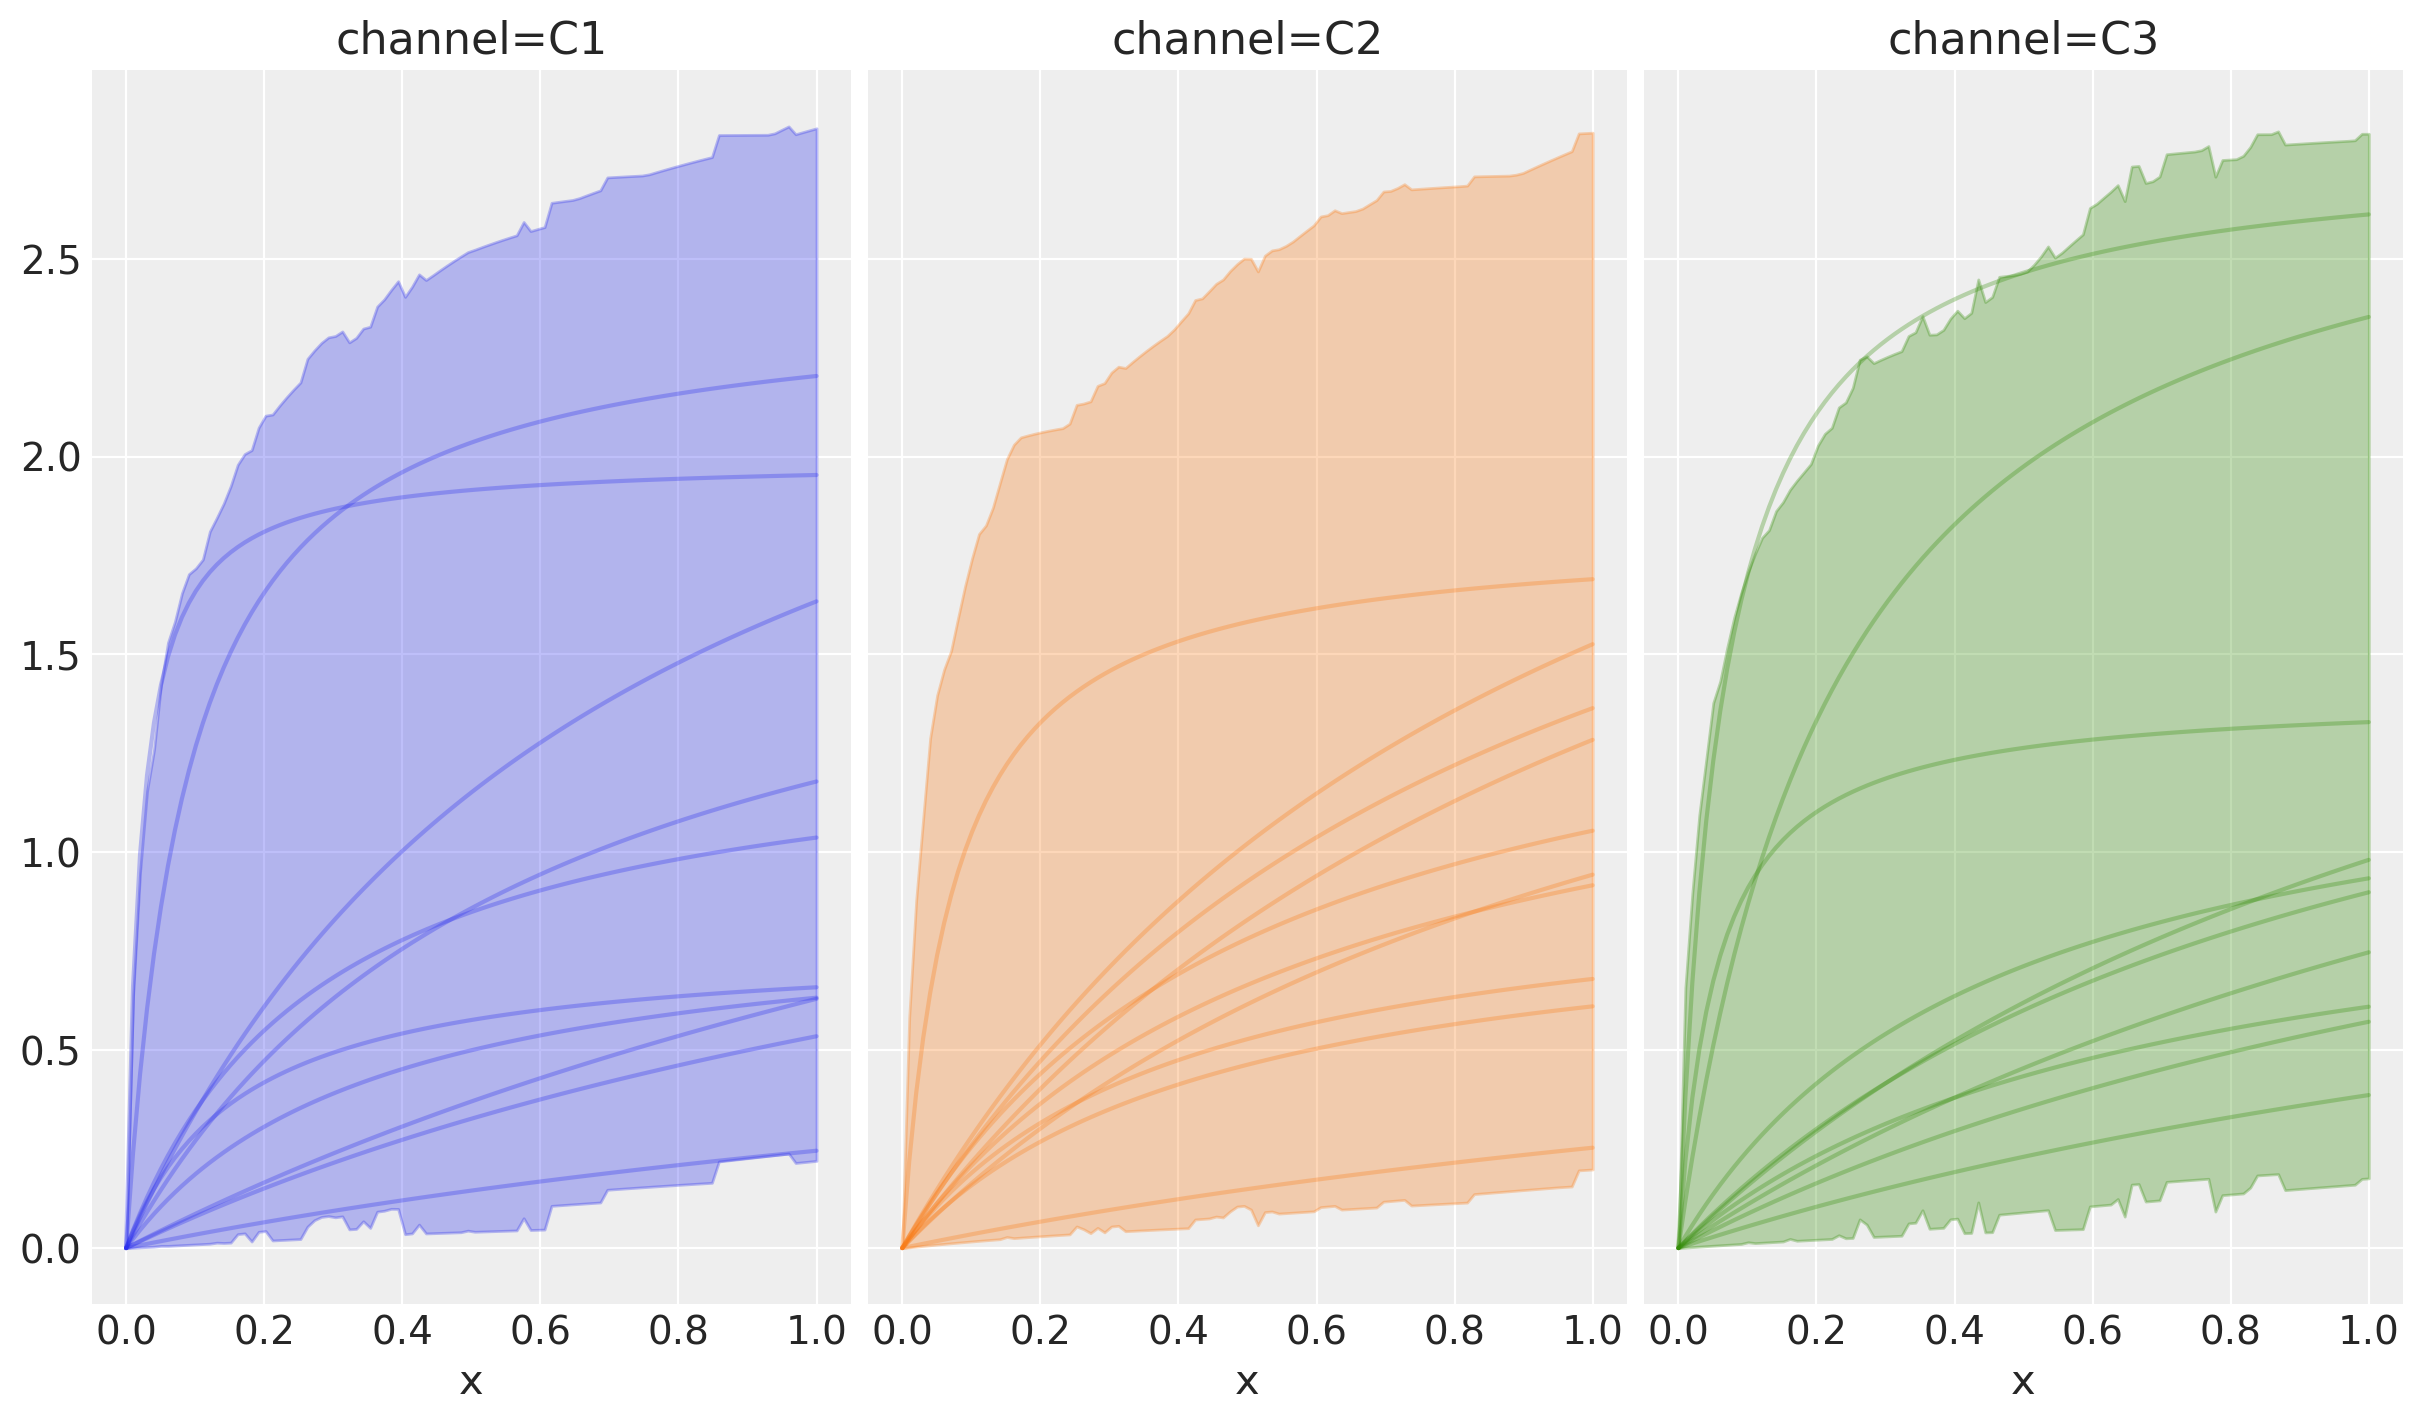

In [18]:
saturation.plot_curve(curve, subplot_kwargs={"sharey": True});

In [11]:
coords = {
    "date": dates,
    "channel": channels,
}
with pm.Model(coords=coords) as model:
    saturated_spends = saturation.apply(spends, dims="channel")

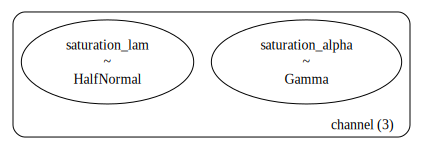

In [12]:
pm.model_to_graphviz(model)

**NOTE:** The `saturated_spends` doesn't show in the model. If needed, save off with `pm.Deterministic`.

Our variable will be (date, channel) dims.

In [20]:
draw(saturated_spends).shape

(104, 3)

### Changing Assumptions

As hinted above, the priors for the function parameters are customizable which can lead to many different models.

The distributions just need to follow the distribution API [here](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.model_config.html).

Instead of the defaults, we can use:
- hierarchical parameter for `lam` parameter
- common `alpha` parameter
  

In [14]:
alpha_distribution =  {
    "dist": "HalfNormal",
    "kwargs": {
        "sigma": {
            "dist": "HalfNormal",
            "kwargs": {"sigma": 1},
        }
    },
    "dims": "channel",
}
priors = {
    "lam": alpha_distribution,
}

saturation = mmm.MichaelisMentenSaturation(priors=priors)

saturation.function_priors

{'alpha': {'dist': 'Gamma', 'kwargs': {'mu': 2, 'sigma': 1}},
 'lam': {'dist': 'HalfNormal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 1}}},
  'dims': 'channel'}}

Then this can be used in a new `PyMC` model!

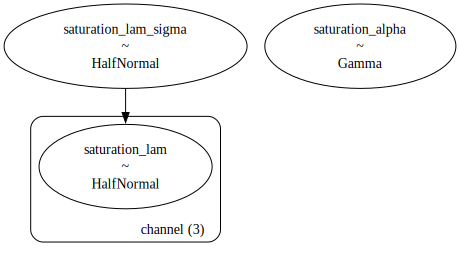

In [15]:
with pm.Model(coords=coords) as model:
    saturated_spends = saturation.apply(spends, dims="channel")

pm.model_to_graphviz(model)

In [16]:
prior = saturation.sample_prior(coords=coords)
curve = saturation.sample_curve(prior)

Sampling: [saturation_alpha, saturation_lam, saturation_lam_sigma]
Sampling: [saturation_lam, saturation_lam_sigma]


Output()

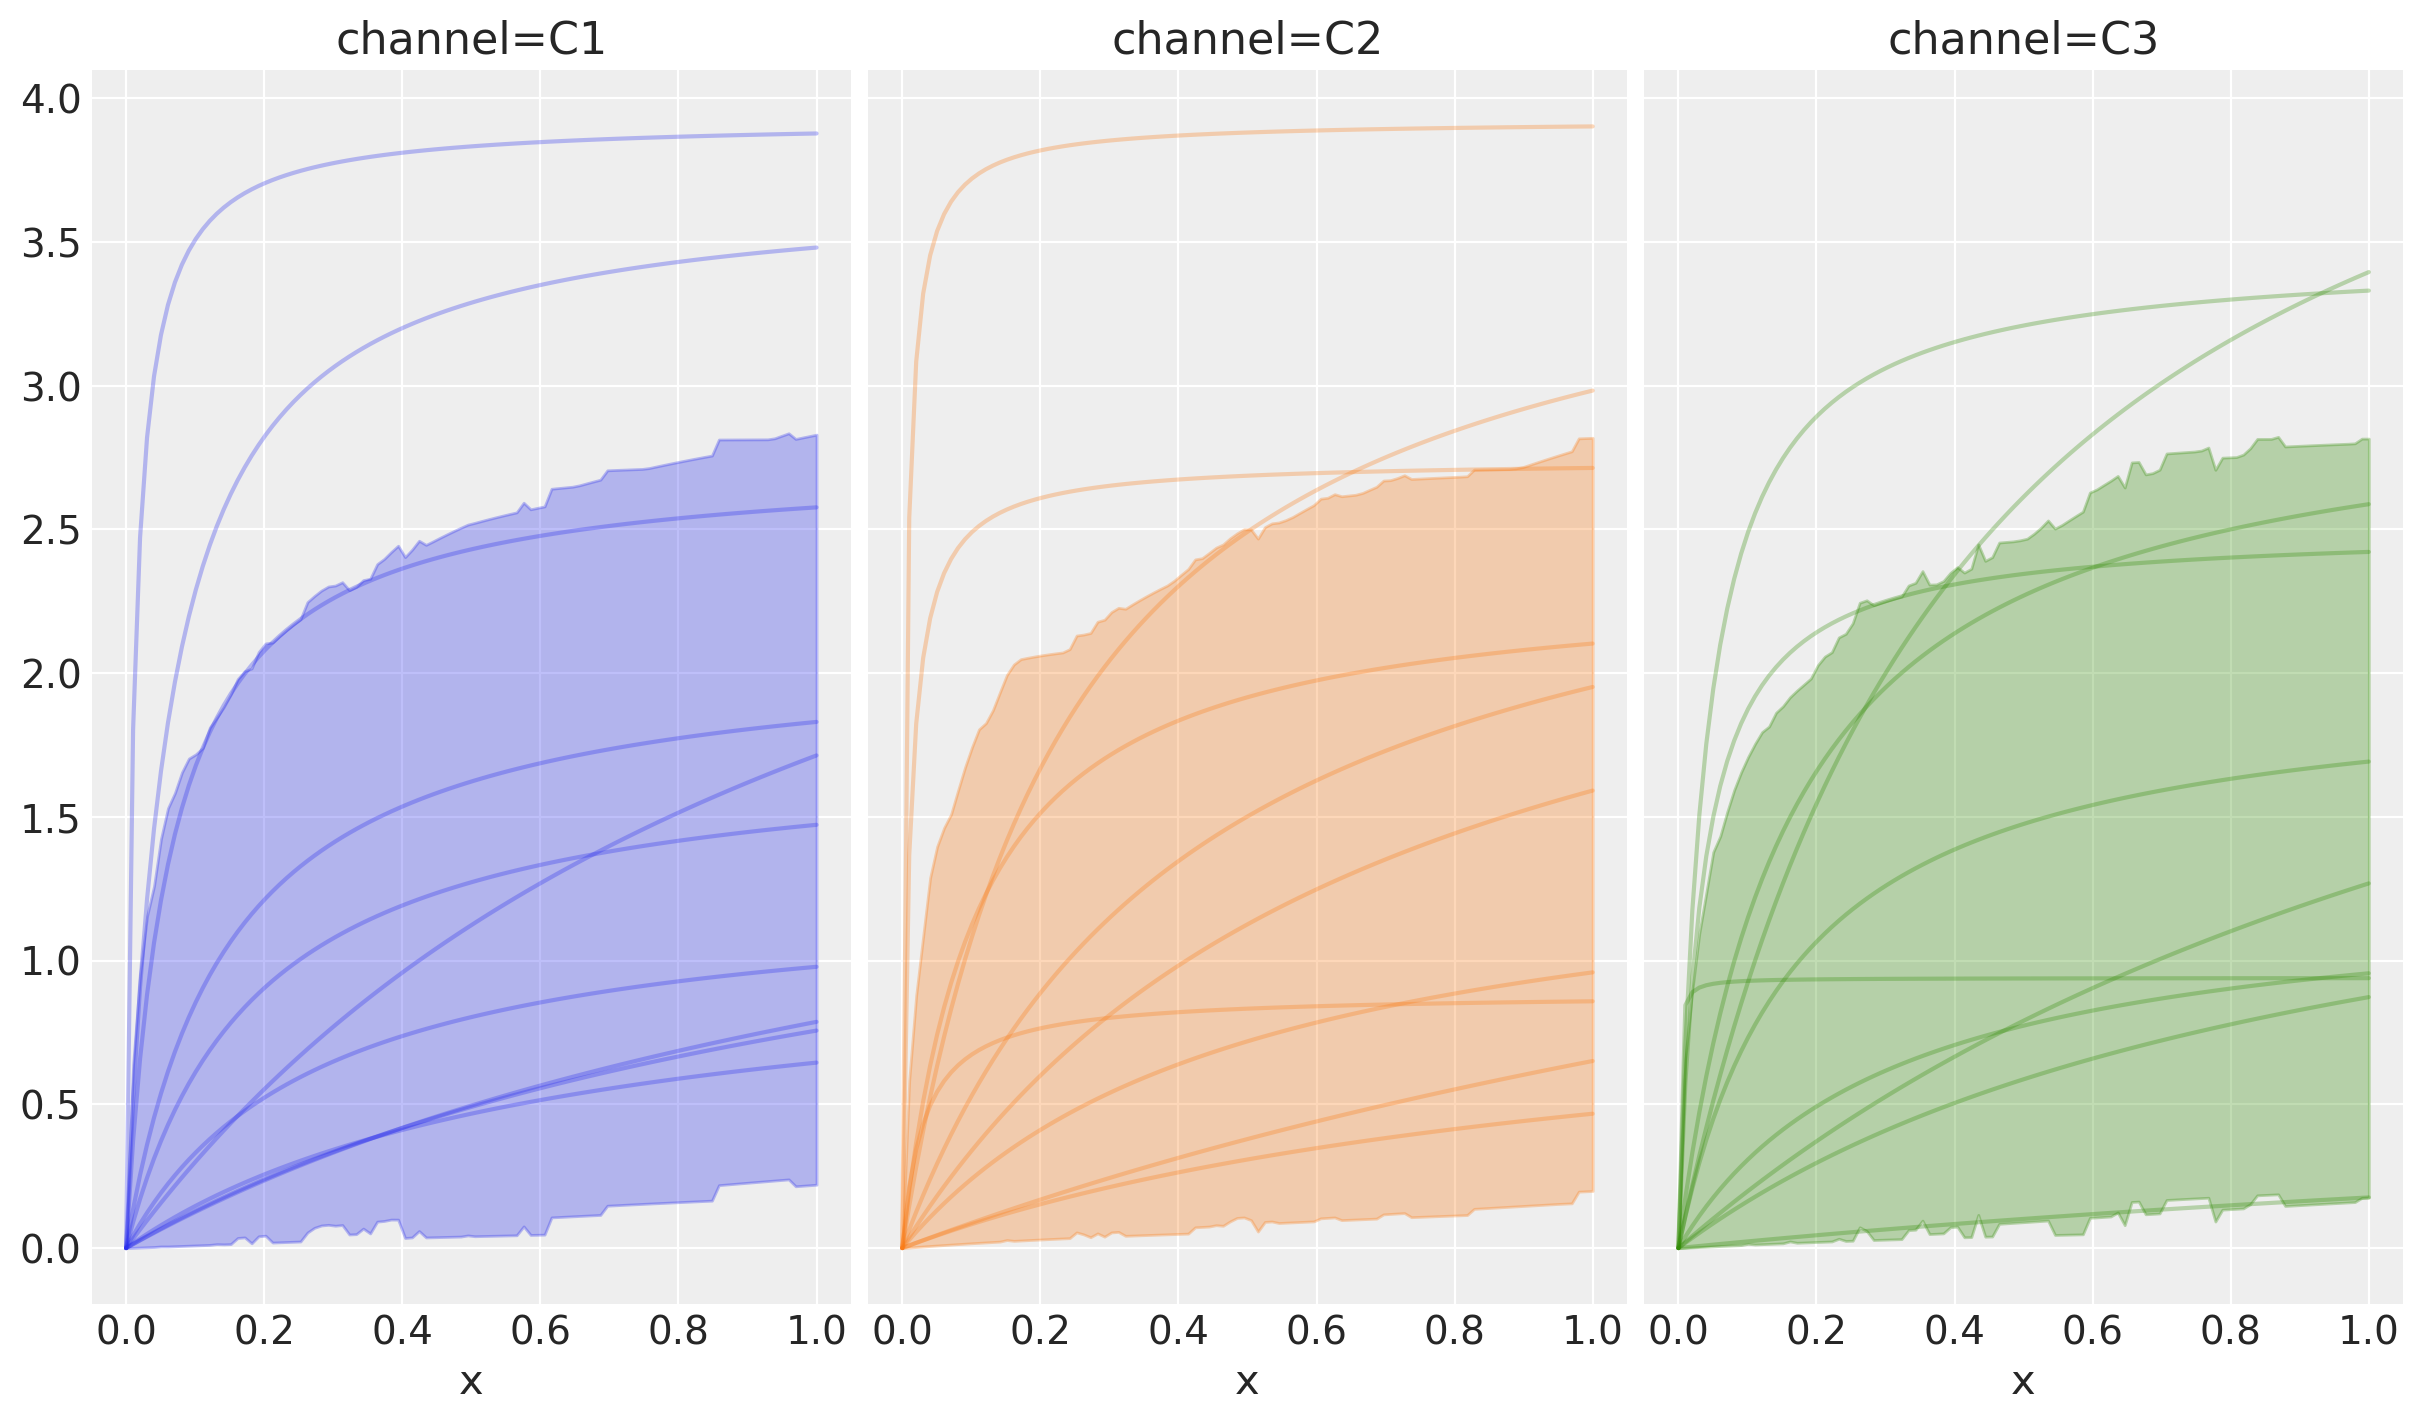

In [17]:
saturation.plot_curve(curve, subplot_kwargs={"sharey": True});

## All together

Lots of flexibility by combining them together

## Summary

Custom models are possible

Highlight what we get from using our prebuilt components